### Spatial Model
1. VIF and Tukey Test to manage explanatory features
2. Moran's I to test for Spatial Autocorrelation
3. Spatial Regression Models (OLS, SLM, SEM)
4. Hot/Cold Analysis
5. GWR

In [1]:
#pip install splot

In [2]:
#pip install -U mgwr

In [3]:
# Import modules

import pandas as pd
import datetime
from datetime import datetime
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from math import sqrt

import pysal as ps
from pysal.explore import esda   # Exploratory Spatial analytics
from pysal.lib import weights
from pysal.model import spreg
from splot.esda import plot_moran
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW

import numpy as np
import random
random.seed(42)
sns.set_theme(style="whitegrid")
pd.options.display.float_format = '{:,.2f}'.format
#sns.set(font_scale=2)

C:\Users\TBD\.conda\envs\dissertation2\lib\site-packages\spaghetti\network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


In [4]:
## Read in data

# Shape Files
spatial_recovery_junpub = gpd.read_file('../output_data/spatial_recovery_junpub.shp')
boroughs = gpd.read_file('../data/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')
msoas = gpd.read_file('../data/statistical-gis-boundaries-london/ESRI/MSOA_2011_London_gen_MHW.shp')


# Set CRS
spatial_recovery_junpub = spatial_recovery_junpub.to_crs('epsg:27700')
boroughs = boroughs.to_crs('epsg:27700')
msoas = msoas.to_crs('epsg:27700')

In [5]:
#spatial_recovery_junpub.info()

In [6]:
df = spatial_recovery_junpub

df.rename({'imd_score_': 'imd_score_std',
                         'total_in_1': 'total_income_std',
                         'cyclelen_1': 'cyclelength_std',
                         'log_cycl_1': 'log_cyclelength_std',
                         'cars_per_1': 'carsperhhld_std',
                         'roadleng_1': 'roadlengths_std',
                         'trips_pe_1': 'trips_std',
                         'log_trip_1': 'log_trips',
                         'educatio_2': 'education_cnt_std',
                         'log_educ_2': 'log_education_cnt',
                         'educatio_3': 'education_den_std',
                         'log_educ_3': 'log_education_den',
                         'pubtrans_1': 'pubtrans_cnt_std',
                         'log_pubt_2': 'log_pubtrans_cnt',
                         'pubtrans_2': 'pubtrans_den_std',
                         'log_pubt_3': 'log_pubtrans_den',
                         'recreati_2': 'recreation_cnt_std',
                         'log_recr_2': 'log_recreation_cnt',
                         'recreati_3' : 'recreation_den_std',
                         'log_recr_3': 'log_recreation_den',
                         'coviddea_2': 'coviddeaths_std',
                         'coviddea_3': 'coviddeaths_den_std'},
                        axis = 1,
                        inplace = True)

#df.info()

### Procedure

1. Feature Selection
2. Spatial Autocorrelation
3. Hotspot Analysis, which will inform how we discuss the strongest model. (i.e, hh/ll for stat significant vars)
4. Spatial Regression Models

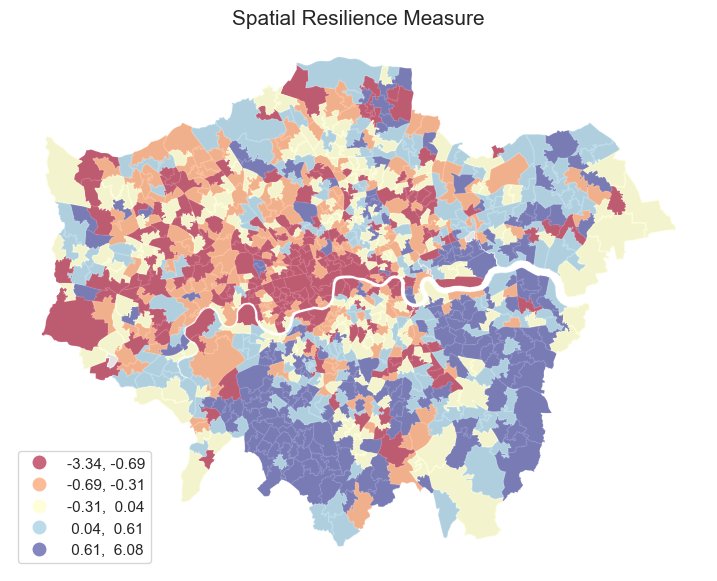

In [7]:
# Plot a chloropeth of slope, code inspired by https://geographicdata.science/book/notebooks/
f, ax = plt.subplots(1, figsize=(9, 9))
sns.set_context('notebook')
#df = spatial_recovery_mar

plotmsoa = msoas.plot(ax=ax,alpha=0.8,color='gainsboro')
plotdf = df.plot(column='slope_std', 
                       cmap='RdYlBu', #Pastel1
                       scheme='quantiles',
                       k=5, 
                       edgecolor='white', 
                       linewidth=0., 
                       alpha=0.6, 
                       legend=True,
                       legend_kwds={'fmt':'{:.2f}',"loc": 3},
                       ax=ax
                      )

ax.set_axis_off()
plotdf.set_title("Spatial Resilience Measure", fontsize = 15)
plt.savefig('../figures/srm_plot.png', dpi = 300)
plt.show()

### Feature Selection
We've created a few versions of the POI variables with various transformations. Here, we explore the correlation with the dependent variable, recovery rate ("slope"). We decided to select the density metrics where POI are a proportion of population density. Then, a VIF is conducted and validated with a correlation matrix.

In [8]:
# Here, we are looking at the correlation with each variable versus slope. Particularly, we're looking to understand where
# the relationship "flips" from negative to positive. Based on what we're seeing, we'll go with the "density" version
# of POIs versus just a count per MSOA. This hopefully accounts for the density of POIs that may impact public transport demand.

df_corr = df[['slope_std',
              'imd_score_std',
              'total_income_std',
              'hw_pct_std',
              'cyclelength_std',
              'log_cyclelength_std',
              'carsperhhld_std',
              'roadlengths_std',
              'trips_std',
              'log_trips',
              'education_cnt_std',
              'log_education_cnt',
              'education_den_std',
              'log_education_den', #strongest of the four
              'pubtrans_cnt_std',
              'log_pubtrans_cnt', #strongest of the four
              'pubtrans_den_std',
              'log_pubtrans_den',
              'recreation_cnt_std',
              'log_recreation_cnt',
              'recreation_den_std',
              'log_recreation_den', #strongest of the four
              'coviddeaths_std',
              'coviddeaths_den_std',
              'pubtrans_d']]

corrMatrix = df_corr.corr(method='pearson')
corrMatrix['slope_std']

slope_std              1.00
imd_score_std         -0.03
total_income_std      -0.11
hw_pct_std            -0.15
cyclelength_std       -0.08
log_cyclelength_std   -0.07
carsperhhld_std        0.21
roadlengths_std       -0.11
trips_std             -0.23
log_trips             -0.29
education_cnt_std     -0.03
log_education_cnt      0.01
education_den_std      0.03
log_education_den      0.07
pubtrans_cnt_std      -0.06
log_pubtrans_cnt      -0.02
pubtrans_den_std      -0.02
log_pubtrans_den       0.09
recreation_cnt_std    -0.01
log_recreation_cnt    -0.01
recreation_den_std     0.01
log_recreation_den     0.05
coviddeaths_std        0.04
coviddeaths_den_std    0.05
pubtrans_d            -0.02
Name: slope_std, dtype: float64

In [9]:
# VIF
# calculating VIF
# This function is partially from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: the max VIF value before the feature is removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            #print(vif_df.VIF)
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df, vif_df

In [10]:
# Running Tukey test to see what should be dropped
test = df
test = test[[#'slope_std',
              'imd_score_std',
              'total_income_std',
              'hw_pct_std',
              'cyclelength_std',
              'carsperhhld_std',
              'roadlengths_std',
              #'trips_std',
              'education_den_std',
              #'busstops_den_std',
              'pubtrans_den_std',
              'recreation_den_std',
              'coviddeaths_std',
              'coviddeaths_den_std']]

#test = test.dropna()

test_2, test_vif = drop_column_using_vif_(test)

Dropping: imd_score_std


In [11]:
# Observing VIF score to see those that are just below the threshold
test_vif

,VIF
total_income_std,4.31
hw_pct_std,3.97
cyclelength_std,1.15
carsperhhld_std,1.95
roadlengths_std,1.59
education_den_std,3.61
pubtrans_den_std,2.45
recreation_den_std,2.40
coviddeaths_std,2.35
coviddeaths_den_std,2.62


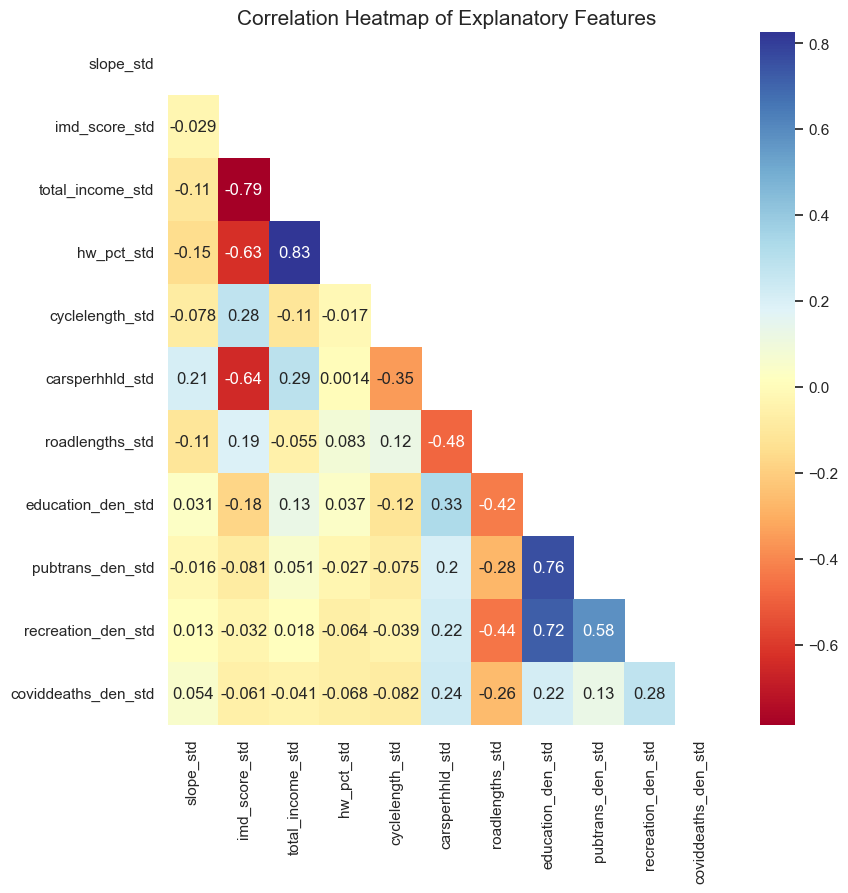

In [12]:
# Correlation Matrix to see which variables have the strongest association with slope
# Code from https://cmdlinetips.com/2020/02/lower-triangle-correlation-heatmap-python/
sns.set_context('notebook')

f, ax = plt.subplots(1, figsize=(9, 9))

df_corr = df[['slope_std',
              'imd_score_std',
              'total_income_std',
              'hw_pct_std',
              'cyclelength_std',
              'carsperhhld_std',
              'roadlengths_std',
              #'trips_std',
              'education_den_std',
              #'busstops_den_std',
              'pubtrans_den_std',
              'recreation_den_std',
              'coviddeaths_den_std']]

corrMatrix = df_corr.corr(method='pearson')
mask_lt = np.triu(np.ones(corrMatrix.shape)).astype(np.bool)
mask_lt[0:13,0:13]
p = sns.heatmap(corrMatrix, mask = mask_lt, cmap='RdYlBu', annot= True)

p.set_title("Correlation Heatmap of Explanatory Features", fontsize = 15)
plt.show()
#plt.savefig('../figures/correlation_matrix.png', dpi = 300)


In [13]:
# Checking to determine number of outliers, may not actually remove.
# Basically, all the outliers identified serve are in an interesting region that has very high recovery rates.

IQR_s = df['slope_std'].quantile(0.75) - df['slope_std'].quantile(0.25)
low_s = df['slope_std'].quantile(0.25) - 1.5*IQR_s
high_s = df['slope_std'].quantile(0.75) + 1.5*IQR_s

outlier_low_s = df[df['slope_std'] < low_s]
outlier_high_s = df[df['slope_std'] > high_s]

outliers = pd.concat([outlier_low_s, outlier_high_s])
outliers.groupby(['region', 'subregion', 'la_name'])['msoa_name'].agg('count')
#outliers[['msoa_name', 'slope']]

region  subregion                  la_name               
Inner   Inner East                 Hackney                    2
                                   Lewisham                   1
                                   Newham                     3
                                   Tower Hamlets              2
        Inner West                 Camden                     1
                                   Kensington and Chelsea     2
                                   Wandsworth                 3
Outer   Outer East and North East  Barking and Dagenham       1
                                   Bexley                     1
                                   Enfield                    2
                                   Greenwich                  2
                                   Waltham Forest             1
        Outer South                Bromley                    1
                                   Croydon                    6
                                   Kingston up

### Spatial Autocorrelation
Create a spatial weights matrix, visualise the neighbours for the report. Calculate bivariate Moran's I for all variables. 

In [14]:
# Create a weights matrix for row-standardisation based on distance

w = weights.distance.KNN.from_dataframe(df, k = 6)
w.transform = 'R'
w

In [15]:
# Add spatial weight of slope to dataframe for Spatial Regression Models

# Assign spatial lag to df
df['w_slope'] = weights.spatial_lag.lag_spatial(w, df['slope_std'])
#df['qW_slope'] = weights.spatial_lag.lag_spatial(qW, df['slope'])
#df['knnW_slope'] = weights.spatial_lag.lag_spatial(w_knn, df['slope'])

In [16]:
# Calculate Moran's I and significance. Moran's I can range from -1 to 1, showing a weak positive autocorrelation in this case.

#df = spatial_recovery_jun#[slope_msoa['slope']<.06]


moran = esda.moran.Moran(df['slope_std'], w)

print(moran.I)
print(moran.p_sim)

0.3881189059543808
0.001


In [17]:
# Calculate a bivariate Moran statistic to understand whether including lags of other variables will add value

#df = spatial_recovery

moran_cols = ['total_income_std',
            'hw_pct_std',
              'cyclelength_std',
              'carsperhhld_std',
              'roadlengths_std',
              'education_den_std',
              'pubtrans_den_std',
              'recreation_den_std',
              'coviddeaths_den_std']

for i in range(0,(len(moran_cols))):
    moranbv = esda.Moran_BV(df['slope_std'], df[moran_cols[i]], w)
    print(moran_cols[i])
    print(moranbv.I)
    print(moranbv.p_sim)


total_income_std
-0.03442143831583087
0.068
hw_pct_std
-0.10068787458939968
0.001
cyclelength_std
-0.08031373119587623
0.001
carsperhhld_std
0.20396278224800024
0.001
roadlengths_std
-0.12120467941785179
0.001
education_den_std
0.027589817697649486
0.114
pubtrans_den_std
0.01999683161001787
0.151
recreation_den_std
0.025746844553151856
0.118
coviddeaths_den_std
0.07023635436227983
0.002


### Hotspot Analysis
To build an intuition of which regions have an unusual behaviour.

In [18]:
## Code practice from https://geographicdata.science/book/notebooks/

# Create metrics for a Moran Plot

# standardise the slope and spatial lag to plot
df['slope_std'] = (df['slope']-df['slope'].mean())/df['slope'].std()
df['w_slope_std'] = (df['w_slope']-df['w_slope'].mean())/df['w_slope'].std()

In [19]:
# Code for Moran Plot
# how to add text to plot for variables: https://notebook.community/ljwolf/ucgis_workshop_2016/notebooks/05%20-%20ESDA

f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
sns.regplot(x='slope_std', y='w_slope_std', data=df, ci=None, line_kws={'color':'r'}, color = '#3333CC')

# Create quadrants
# Add vertical, horizontal lines at origin and labels
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)
plt.text(2, 2, "HH", fontsize=10)
plt.text(2, -2, "HL", fontsize=10)
plt.text(-2, 2, "LH", fontsize=10)
plt.text(-2, -2, "LL", fontsize=10)
#plt.show()

Text(-2, -2, 'LL')

In [20]:
# Calculate Moran's I for each datapoint
lisa = esda.moran.Moran_Local(df['slope'],w)

# add to df, set back to main dataframe
df['Is'] = lisa.Is

In [21]:
# Count the number of datapoints within each quadrant, perhaps if evenly distributed then this is purely random
# 1 = HH, 2 = LH, 3 = LL, 4 = HL
# results show that 23 are in HH/LL, balance in LH/HL.
counts = [(j,(lisa.q == j).sum()) for j in range(1,5)]
print(counts)

[(1, 273), (2, 137), (3, 438), (4, 133)]


In [22]:
# Furthermore, we'll assign each value to a cluster based on its significance of autocorrelation
sig = 1*(lisa.p_sim < 0.05) # binary to indicate which msoas are significant
df['p-sim'] = lisa.p_sim
df['sig'] = sig
#df[['msoa_name','sig', 'p-sim']].head()

In [23]:
# Now we label the data with not-significant, hh, ll, hl, lh. 

hh = 1*(sig*lisa.q==1)
ll = 3*(sig*lisa.q==3)
lh = 2*(sig*lisa.q==2)
hl = 4*(sig*lisa.q==4)
spots = hh + ll + lh + hl
spot_labels = ['0 ns', '1 hh', '2 lh', '3 ll', '4 hl']
labels = [spot_labels[i] for i in spots]
df['labels'] = labels

df = df
[(spot_label, (df['labels']==spot_label).sum()) for spot_label in spot_labels]

[('0 ns', 706), ('1 hh', 105), ('2 lh', 33), ('3 ll', 117), ('4 hl', 20)]

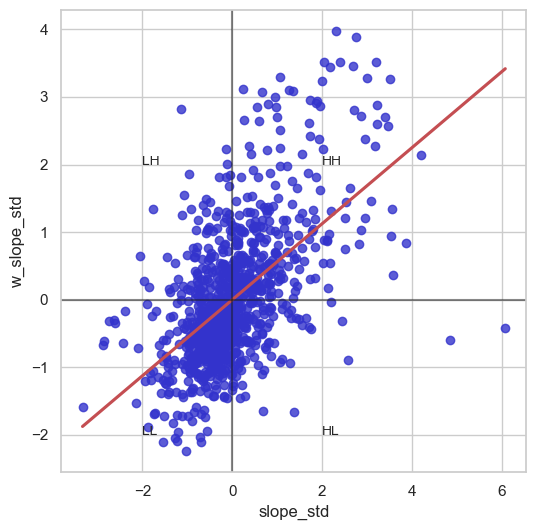

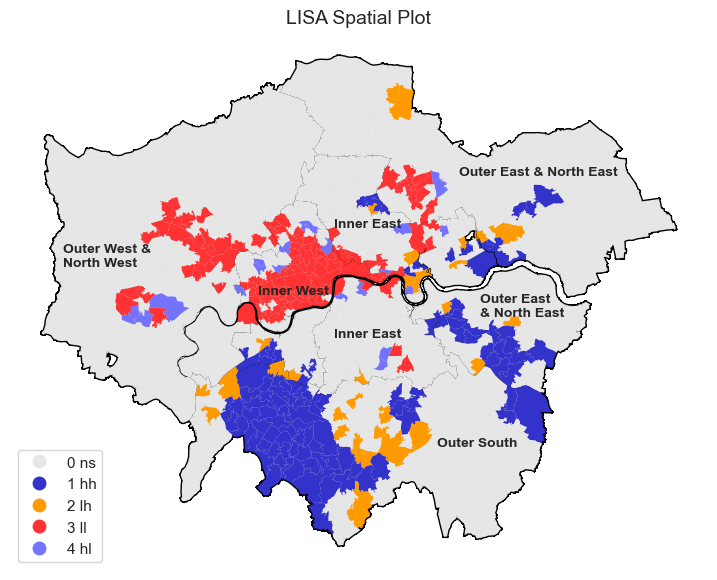

In [24]:
# Plot labels based on significance
# Based on this, we can visually see that it is central and west london that appear to be in the ll quadrant significantly, only Redbridge in the hh quadrant is significant.
# Based on the Moran plot, those that are negative are statistically significantly below the mean standardised slope of all local authorities.

sns.set_context('notebook')

f, ax = plt.subplots(1, figsize=(9,9))
hmap = colors.ListedColormap(['#E7E6E6', '#3333CC', '#FF9B00', '#FF3333', '#7373FF'])

df_sr = df[['subregion', 'geometry']]
df_sr['geometry'] = df_sr['geometry'].buffer(0.0001)
df_sr = df_sr.dissolve(by = 'subregion').reset_index()
#df_test = df.overlay(df_sr, how = 'intersection')
plot_sr = df_sr.plot(column = 'subregion',
           color = 'gainsboro',
           edgecolor = 'black',
           linewidth = 2,
           ax = ax)

df.plot(column='labels', categorical=True, 
        k=2, cmap=hmap, linewidth=0.0000001, ax=ax,
        edgecolor='gainsboro',legend_kwds={"loc": 3}, legend=True)

ax.text(523500, 179000, "Inner West", fontsize=10, fontweight = 'bold')
ax.text(530500, 185150, "Inner East", fontsize=10, fontweight = 'bold')
ax.text(530500, 175000, "Inner East", fontsize=10, fontweight = 'bold')
ax.text(505500, 181600, "Outer West & \nNorth West", fontsize=10, fontweight = 'bold')
ax.text(542000, 190000, "Outer East & North East", fontsize=10, fontweight = 'bold')
ax.text(543900, 177000, "Outer East \n& North East", fontsize=10, fontweight = 'bold')
ax.text(540000, 165000, "Outer South", fontsize=10, fontweight = 'bold')

ax.set_axis_off()
ax.set_title("LISA Spatial Plot", fontsize = 14)
plt.savefig('../figures/lisa_spatial.jpeg', dpi = 300)
plt.show()

### Spatial Regression Model
Regression Models created: OLS, Spatial Lag, Spatial Error, and GWR.

In [25]:
# Spatial Regression Models: OLS, Spatial Lag, Spatial Error
# http://andrewgaidus.com/Spatial_Econonometric_Modeling/

y = df['slope_std']

cols = ['total_income_std',
        'hw_pct_std',
        'cyclelength_std',
        'carsperhhld_std',
        'roadlengths_std',
        'education_den_std',
        'pubtrans_den_std',
        'recreation_den_std',
        'coviddeaths_den_std']

x = df.loc[:, cols]
#x.values

In [26]:
model_ols = spreg.OLS(y.values[:, None], x.values, w=w, spat_diag = True, moran = True, name_x = cols, name_y = 'slope_std')
moran_ols = esda.moran.Moran(model_ols.u, w)

print(model_ols.summary)
print(moran_ols.I)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   slope_std                Number of Observations:         981
Mean dependent var  :      0.0000                Number of Variables   :          10
S.D. dependent var  :      1.0000                Degrees of Freedom    :         971
R-squared           :      0.0810
Adjusted R-squared  :      0.0724
Sum squared residual:     900.652                F-statistic           :      9.5051
Sigma-square        :       0.928                Prob(F-statistic)     :   5.693e-14
S.E. of regression  :       0.963                Log likelihood        :   -1350.064
Sigma-square ML     :       0.918                Akaike info criterion :    2720.127
S.E of regression ML:      0.9582                Schwarz criterion     :    2769.013

-----------------------------------------------------------------------------

In [27]:
# OLS with Spatial Weights in x
cols = ['total_income_std',
        'hw_pct_std',
        'cyclelength_std',
        'carsperhhld_std',
        'roadlengths_std',
        'education_den_std',
        'pubtrans_den_std',
        'recreation_den_std',
        'coviddeaths_den_std',
        'w_slope']
x = df.loc[:, cols]

model2 = spreg.OLS(y.values[:, None], x.values, w=w, spat_diag = True, moran = True, name_x = cols, name_y = 'slope_std')
print(model2.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   slope_std                Number of Observations:         981
Mean dependent var  :      0.0000                Number of Variables   :          11
S.D. dependent var  :      1.0000                Degrees of Freedom    :         970
R-squared           :      0.3337
Adjusted R-squared  :      0.3269
Sum squared residual:     652.947                F-statistic           :     48.5861
Sigma-square        :       0.673                Prob(F-statistic)     :    8.78e-79
S.E. of regression  :       0.820                Log likelihood        :   -1192.308
Sigma-square ML     :       0.666                Akaike info criterion :    2406.615
S.E of regression ML:      0.8158                Schwarz criterion     :    2460.389

-----------------------------------------------------------------------------

In [28]:
# Spatial Lag model
cols = ['total_income_std',
        'hw_pct_std',
        'cyclelength_std',
        'carsperhhld_std',
        'roadlengths_std',
        'education_den_std',
        'pubtrans_den_std',
        'recreation_den_std',
        'coviddeaths_den_std']

x = df.loc[:, cols]
x = x.astype(np.float64)

model_lag = spreg.GM_Lag(y.values[:, None], x.values, w=w, spat_diag = True, name_x = cols, name_y = 'slope_std')
moran_lag = esda.moran.Moran(model_lag.u, w)
print(model_lag.summary)
print(f"Moran's I of Residuals:{moran_lag.I}, significance: {moran_lag.p_sim}")
print(f"AIC {spreg.diagnostics.akaike(model_lag)}")

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   slope_std                Number of Observations:         981
Mean dependent var  :      0.0000                Number of Variables   :          11
S.D. dependent var  :      1.0000                Degrees of Freedom    :         970
Pseudo R-squared    :      0.3300
Spatial Pseudo R-squared:  0.0637

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      -0.0077054       0.0264917      -0.2908601       0.7711583
    total_income_std      -0.1697671       0.0548079      -3.0974903       0.0019517
          hw_pct_std       0.0410206       0.0563624       

In [29]:
# Spatial Error Model, treats spatial autocorrelation as a 'nuisance' in the lambda variable.

model_error = spreg.GM_Error_Het(y.values[:, None], x.values, w=w, name_x = cols, name_y = 'slope_std')
moran_error = esda.moran.Moran(model_error.u, w)
print(model_error.summary)
print(f"Moran's I of Residuals:{moran_error.I}, significance: {moran_error.p_sim}")
#print(f"AIC {spreg.diagnostics.akaike(model_error)}")

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED LEAST SQUARES (HET)
---------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   slope_std                Number of Observations:         981
Mean dependent var  :      0.0000                Number of Variables   :          10
S.D. dependent var  :      1.0000                Degrees of Freedom    :         971
Pseudo R-squared    :      0.0756
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      -0.0164102       0.0676170      -0.2426942       0.8082423
    total_income_std      -0.2216733       0.0696129      -3.1843711       0.00

In [30]:
# Create parameters for GWR
g_coords = list(zip(df.centroid.x, df.centroid.y))

g_y = y.values.reshape((-1,1))
g_x = x.values

In [31]:
# Select bandwidth for the GWR model

selector = Sel_BW(g_coords, g_y, g_x, spherical = False)
bw = selector.search()
print(bw)

333.0


In [32]:
# https://github.com/pysal/gwr/blob/master/gwr/notebooks/GWR_Georgia_Example.ipynb

#Find optimal bandwidth using golden section search to minimize AICc

#Instantiate bandwidth selection class - bisquare NN (adaptive)
bw = Sel_BW(g_coords, g_y, g_x, kernel='bisquare', fixed=False)

#Find optimal bandwidth by minimizing AICc using golden section search algorithm
bw = bw.search('golden_section', criterion='AICc')
print(bw)



333.0


In [33]:
# GWR

model_gwr = GWR(g_coords, g_y, g_x, bw).fit()
model_gwr.summary()
moran_gwr = esda.moran.Moran(model_gwr.resid_response, w)
print(f"Moran's I of Residuals:{moran_gwr.I}, significance: {moran_gwr.p_sim}")
print(f"AIC {model_gwr.aic}")

Model type                                                         Gaussian
Number of observations:                                                 981
Number of covariates:                                                    10

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            900.652
Log-likelihood:                                                   -1350.064
AIC:                                                               2720.127
AICc:                                                              2722.400
BIC:                                                              -5788.152
R2:                                                                   0.081
Adj. R2:                                                              0.072

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [34]:
#selector = Sel_BW(g_coords, g_y, g_x, multi=True)
#bw = selector.search(multi_bw_min=[2], multi_bw_max=[341])
#modelmgwr = MGWR(g_coords, g_y, g_x, selector).fit()
#modelmgwr.summary()

In [35]:
df['R2'] = model_gwr.localR2

In [36]:
#model_gwr.filter_tvals()
#model_gwr.params[:,2]
#model_gwr.params.shape
#model_gwr.params.shape[1]
#x.columns

### Spatial Visualisations of Regression Outputs


In [37]:
# Apply bivariate LISA significance labels to variables

bv_cols = ['total_income_std', 'hw_pct_std', 'cyclelength_std', 'carsperhhld_std',
       'roadlengths_std', 'education_den_std', 'pubtrans_den_std',
       'recreation_den_std', 'coviddeaths_den_std']

for i in range(0, len(bv_cols)):
    lisa_bv = esda.Moran_Local_BV(df[bv_cols[i]], df['slope_std'], w)
    # add to df, set back to main dataframe
    df[f"{str(bv_cols[i])}_Is"] = lisa_bv.Is
    
    sig = 1*(lisa_bv.p_sim < 0.05) # binary to indicate which msoas are significant
    df[f"{str(bv_cols[i])}_p-sim"] = lisa_bv.p_sim
    df[f"{str(bv_cols[i])}_sig"] = sig
    #df[['msoa_name','sig', 'p-sim']].head()
    # Now we label the data with not-significant, hh, ll, hl, lh. 
    hh = 1*(sig*lisa_bv.q==1)
    ll = 3*(sig*lisa_bv.q==3)
    lh = 2*(sig*lisa_bv.q==2)
    hl = 4*(sig*lisa_bv.q==4)
    spots = hh + ll + lh + hl
    spot_labels = ['0 ns', '1 hh', '2 lh', '3 ll', '4 hl']
    labels = [spot_labels[i] for i in spots]
    df[f"{str(bv_cols[i])}_labels"] = labels
    df = df
    [(spot_label, (df[f"{str(bv_cols[i])}_labels"]==spot_label).sum()) for spot_label in spot_labels]

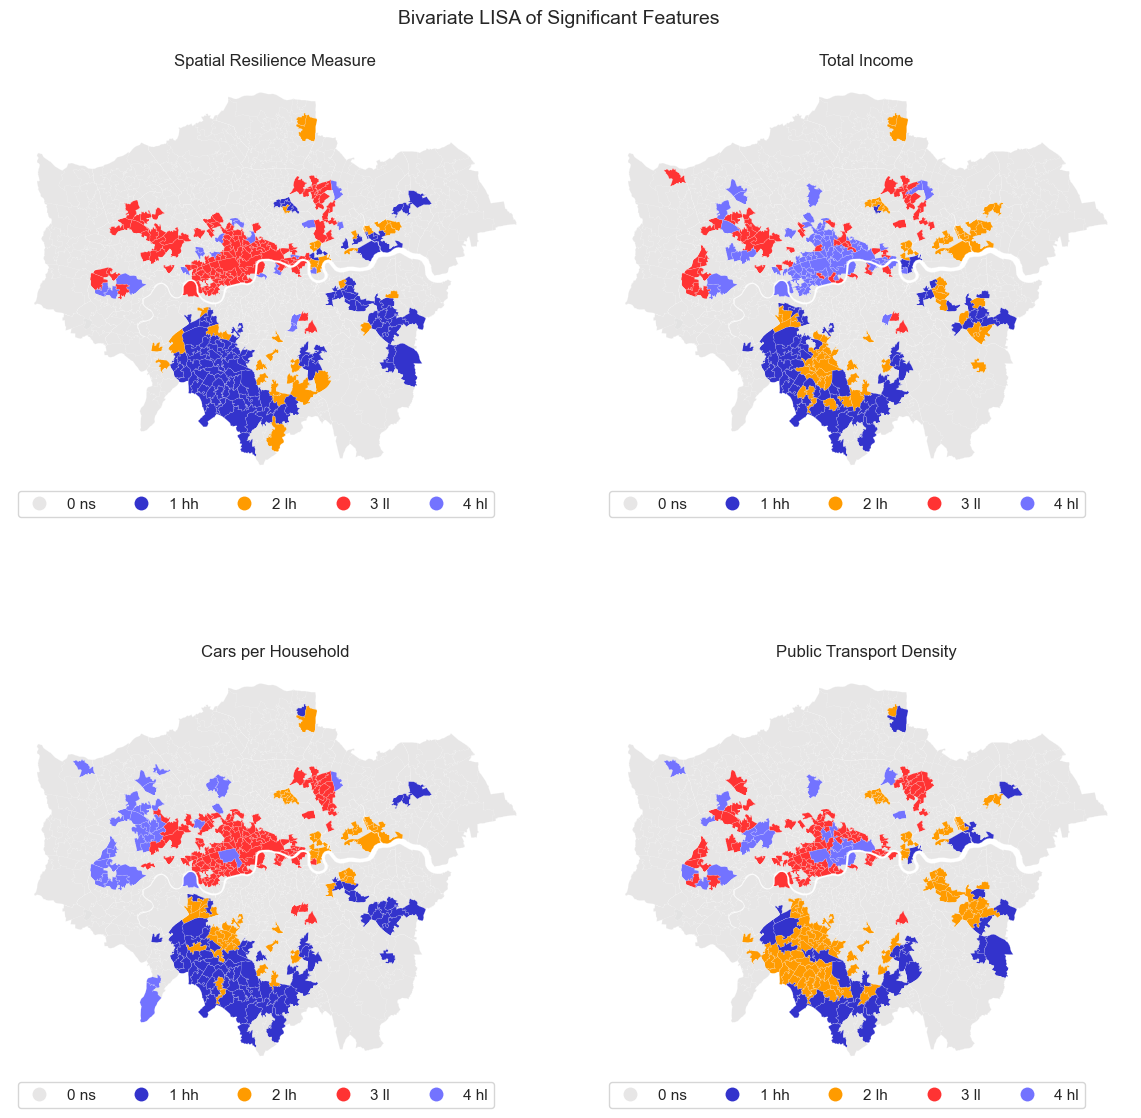

In [38]:
# Plot labels based on significance
# Based on this, we can visually see that it is central and west london that appear to be in the ll quadrant significantly, only Redbridge in the hh quadrant is significant.
# Based on the Moran plot, those that are negative are statistically significantly below the mean standardised slope of all local authorities.
sns.set_context('notebook')

f,ax = plt.subplots(2,2, figsize = (12,12), subplot_kw = dict(aspect = 'equal'))
ax = ax.flatten()
f.tight_layout()

hmap = colors.ListedColormap(['#E7E6E6', '#3333CC', '#FF9B00', '#FF3333', '#7373FF'])


plot_cols = ['labels','total_income_std_labels', 'carsperhhld_std_labels', 'pubtrans_den_std_labels']
plot_titles = ['Spatial Resilience Measure', 'Total Income', 'Cars per Household', 'Public Transport Density']


for i in range(0, len(plot_cols)):
    plotmsoa = boroughs.plot(ax=ax[i],alpha=0.8,color='gainsboro')
    df.plot(column=plot_cols[i], categorical=True, 
        k=2, cmap=hmap, linewidth=0.1, ax=ax[i],
        edgecolor='white',legend_kwds={"loc": 3, 'bbox_to_anchor':(0, -0.10), 'ncol':5}, legend=True)
    ax[i].set_title(plot_titles[i], fontsize = 12)
    ax[i].set_axis_off()
    
f.suptitle('Bivariate LISA of Significant Features', fontsize = 14)
plt.savefig('../figures/bivariate_lisa.jpeg', dpi = 300)
plt.show()
# Total Income: h/h = high income, high recovery rate. l/h = low income, high recovery rate. ll = low income, low recovery.
# h/l = high lincome, low recovery. 